In [1]:
from contra_qa.text_generation.boolean2_S_and import boolean2
from contra_qa.text_processing.functions import simple_pre_process_text_df
from contra_qa.plots.functions  import plot_histogram_from_labels, plot_confusion_matrix

from contra_qa.train_functions.RNNConfig import RNNConfig
import numpy as np
import torch
import torch.nn as nn
from torchtext import data

import pandas as pd
import  matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

% matplotlib inline

# manipulating datasets: b2

In [2]:
boolean2()

In [3]:
df2 = pd.read_csv("data/boolean2_train.csv")
df2test = pd.read_csv("data/boolean2_test.csv")

In [4]:
df2.tail()

,sentence1,sentence2,and_A,and_B,label
9995,Debra is victorious and Jim is thankful,Debra is not victorious,Debra is victorious,Jim is thankful,1
9996,Lance is nice and Gene is ambitious,Lance is not nice,Lance is nice,Gene is ambitious,1
9997,Louis is brave and Beth is gentle,Priscilla is inexpensive,Louis is brave,Beth is gentle,0
9998,Charlotte is brave and Sherry is wrong,Charlotte is not wrong,Charlotte is brave,Sherry is wrong,0
9999,Kay is calm and June is wonderful,Kay is not calm,Kay is calm,June is wonderful,1


In [5]:
df2test.tail()

,sentence1,sentence2,and_A,and_B,label
995,Chester is obedient and Jim is wonderful,Claudia is not mealy,Chester is obedient,Jim is wonderful,0
996,Marlene is brave and Wilma is eager,Marlene is not brave,Marlene is brave,Wilma is eager,1
997,Eleanor is powerful and Jeff is gifted,Jeff is not gifted,Eleanor is powerful,Jeff is gifted,1
998,Derek is kind and Nathaniel is gentle,Derek is not kind,Derek is kind,Nathaniel is gentle,1
999,Nicole is vast and Crystal is hallowed,Crystal is not hallowed,Nicole is vast,Crystal is hallowed,1


In [6]:
df2train = df2.iloc[:8500]
df2valid = df2.iloc[8500:]

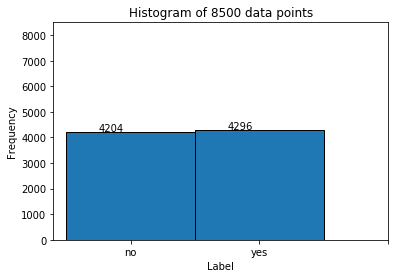

In [7]:
plot_histogram_from_labels(df2train.label.values, ["no", "yes"], "test.png") 

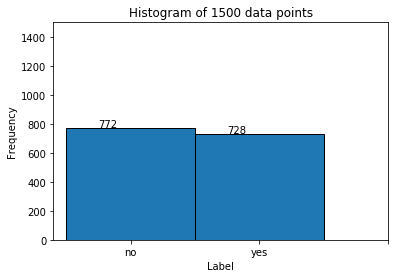

In [8]:
plot_histogram_from_labels(df2valid.label.values, ["no", "yes"], "test.png")

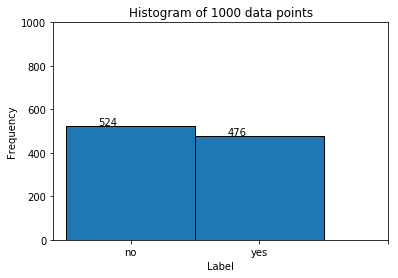

In [9]:
plot_histogram_from_labels(df2test.label.values, ["no", "yes"], "test.png") 

In [10]:
simple_pre_process_text_df(df2, "sentence1")
simple_pre_process_text_df(df2, "sentence2")
simple_pre_process_text_df(df2, "and_A")
simple_pre_process_text_df(df2, "and_B")

df2["text"] = df2["sentence1"] + ", " + df2["sentence2"]

# creating vocab and tensor data

In [11]:
df2_little = df2[["text", "label"]]

In [12]:
df2_little.head()

,text,label
0,"kay is vast and vivian is poor, vivian is not ...",1
1,"clara is eager and antonio is brave, ryan is n...",0
2,"alvin is victorious and minnie is nice, steve ...",0
3,"antonio is polite and rosa is wonderful, gabri...",0
4,"cathy is unimportant and paul is hallowed, pau...",1


In [13]:
train_data_path = "data/boolean_2_train_lab.csv"
df2_little.to_csv(train_data_path, header=False, index=False)

In [14]:
TEXT = data.Field()
LABEL = data.LabelField(tensor_type=torch.FloatTensor)
train = data.TabularDataset(path=train_data_path,
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])

In [15]:
TEXT.build_vocab(train, max_size=25000)
LABEL.build_vocab(train)

In [16]:
print('len(TEXT.vocab):', len(TEXT.vocab))
print('len(LABEL.vocab):', len(LABEL.vocab))

len(TEXT.vocab): 753
len(LABEL.vocab): 2


In [17]:
def finde_size(list_):
    return np.max(list(map(lambda x: len(x.split(" ")), list_)))

In [18]:
def str_list2tensor(list_):
    list_i = []
    max_size = finde_size(list_)
    for line in list_:
        line = line.split(" ")
        size = len(line) 
        tail = max_size - size
        line += [TEXT.pad_token] * tail
        new_line = [TEXT.vocab.stoi[word] for word in line]
        list_i.append(new_line)
    return torch.tensor(list_i, dtype=torch.long, device=device)
    

In [19]:
exampleS1_train_t = str_list2tensor(list(df2train.sentence1.values))
exampleS2_train_t = str_list2tensor(list(df2train.sentence2.values))
exampleA_train_t = str_list2tensor(list(df2train.and_A.values))
exampleB_train_t = str_list2tensor(list(df2train.and_B.values))
exampleLabel_train = torch.tensor(list(df2train.label.values), dtype=torch.long, device=device)

In [20]:
exampleS1_valid_t = str_list2tensor(list(df2valid.sentence1.values))
exampleS2_valid_t = str_list2tensor(list(df2valid.sentence2.values))
exampleA_valid_t = str_list2tensor(list(df2valid.and_A.values))
exampleB_valid_t = str_list2tensor(list(df2valid.and_B.values))
exampleLabel_valid = torch.tensor(list(df2valid.label.values), dtype=torch.long, device=device)

In [21]:
exampleS1_test_t = str_list2tensor(list(df2test.sentence1.values))
exampleS2_test_t = str_list2tensor(list(df2test.sentence2.values))
exampleA_test_t = str_list2tensor(list(df2test.and_A.values))
exampleB_test_t = str_list2tensor(list(df2test.and_B.values))
exampleLabel_test = torch.tensor(list(df2test.label.values), dtype=torch.long, device=device)

In [22]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(exampleS1_train_t, exampleS2_train_t, exampleA_train_t, exampleB_train_t, exampleLabel_train)
valid_dataset = TensorDataset(exampleS1_valid_t, exampleS2_valid_t, exampleA_valid_t, exampleB_valid_t, exampleLabel_valid)
test_dataset = TensorDataset(exampleS1_test_t, exampleS2_test_t, exampleA_test_t, exampleB_test_t, exampleLabel_test)

In [23]:
from torch.utils.data import DataLoader

class DataHolder():
    """
    Class to store all data using the GentleLoader.

    :param config: hyper params configuration
    :type config: LRConfig or DFNConfig
    :param train_dataset: dataset of training data
    :type train_dataset: torch.utils.data.dataset.TensorDataset
    :param test_dataset: dataset of test data
    :type test_dataset: torch.utils.data.dataset.TensorDataset
    :param valid_dataset: dataset of valid data
    :type valid_dataset: torch.utils.data.dataset.TensorDataset
    :param batch_size: batch size for training
    :type test_batch: batch size for the testing data
    :param test_batch: int
    """
    def __init__(self,
                 config,
                 train_dataset,
                 valid_dataset,
                 test_dataset,
                 test_batch=1000):
        batch_size = config.batch_size
        self.train_loader = DataLoader(dataset=train_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
        self.valid_loader = DataLoader(dataset=valid_dataset,
                                         batch_size=batch_size,
                                         shuffle=True)
        self.test_loader = DataLoader(dataset=test_dataset,
                                        batch_size=test_batch,
                                        shuffle=True)

In [24]:
config = RNNConfig()
b_data = DataHolder(config,
                    train_dataset,
                    valid_dataset,
                    test_dataset)

# defining the model

In [25]:
class AddRNN(nn.Module):
    def __init__(self, config):
        super(AddRNN, self).__init__()
        self.vocab_size = config.vocab_size
        self.embedding_dim = config.embedding_dim
        self.output_dim = config.output_dim
        self.rnn_dim = config.rnn_dim
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.rnn = nn.GRU(self.embedding_dim, self.rnn_dim) 
        self.fcA = nn.Linear(self.rnn_dim, self.rnn_dim)
        self.fcB = nn.Linear(self.rnn_dim, self.rnn_dim)
        self.fc_out = nn.Linear(self.rnn_dim, self.output_dim)
        self.fc_inf = nn.Linear(self.rnn_dim * 2, self.rnn_dim)
        
        
    def encode(self, x, hidden=None):
        if hidden is None:
            hidden = torch.zeros((1, x.shape[1], self.rnn_dim), device=device)
        embedded = self.embedding(x)       
        output, hidden = self.rnn(embedded, hidden)
        hidden = hidden.squeeze(0)
        return hidden

    def forward(self, s1, s2):
        s1 = s1.view((s1.shape[1], s1.shape[0]))
        s2 = s2.view((s2.shape[1], s2.shape[0]))
        c = torch.cat([s1, s2], dim=1)
        c = c.view((c.shape[1], c.shape[0]))
        h = self.encode(c)
        out = self.fc_out(h)
        
#         h = self.encode(s1)
#         self.ha = self.fcA(h)
#         self.hb = self.fcB(h)
# #         h_inf = self.ha + self.hb
# #         h_inf = self.ha * self.hb
#         h_inf = self.fc_inf(torch.cat([self.ha, self.hb], dim=1))
#         h_inf = h_inf.view((1, h_inf.shape[0], h_inf.shape[1]))
#         s2_enc = self.encode(s2, h_inf)
#         out = self.fc_out(s2_enc)
        return out

    def predict(self, s1, s2):
        out = self.forward(s1, s2)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

    def evaluate_labels(self,s1, s2, labels):
        prediction = self.predict(s1, s2)
        correct = torch.sum(torch.eq(prediction, labels)).float()
        accuracy = float(correct / labels.shape[0])
        prediction = prediction.numpy()
        labels = labels.numpy()
        return accuracy, prediction, labels

In [26]:
s1, s2, and_A, and_B, label = next(iter(b_data.train_loader))
s1 = s1.view((s1.shape[1], s1.shape[0]))
s2 = s2.view((s2.shape[1], s2.shape[0]))
and_A = and_A.view((and_A.shape[1], and_A.shape[0]))
and_B = and_B.view((and_B.shape[1], and_B.shape[0]))

In [27]:
config = RNNConfig(vocab_size=len(TEXT.vocab))
print(config)

vocab_size = 753
batch_size = 32
embedding_dim = 100
rnn_dim = 100
output_dim = 2
epochs = 8
learning_rate = 0.01
momentum = 0.2



In [28]:
model = AddRNN(config)

out = model.predict(s1, s2)
print(out)

tensor([0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0])


mean valid acc before training =  0.509375


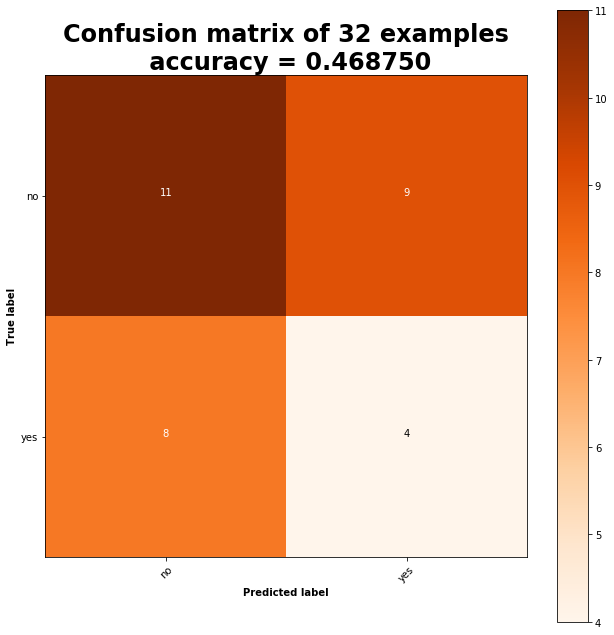

In [29]:
all_acc = 0
n_iter = 10
for i in range(n_iter):
    s1, s2, and_A, and_B, labels = next(iter(b_data.valid_loader))
    s1 = s1.view((s1.shape[1], s1.shape[0]))
    s2 = s2.view((s2.shape[1], s2.shape[0]))
    and_A = and_A.view((and_A.shape[1], and_A.shape[0]))
    and_B = and_B.view((and_B.shape[1], and_B.shape[0]))
    acc, prediction, labels = model.evaluate_labels(s1, s2, labels)
    all_acc += acc

print("mean valid acc before training =  {}".format(all_acc / n_iter))    
plot_confusion_matrix(labels,
                      prediction,
                      classes=["no", "yes"],
                      path="confusion_matrix.png")

# defining the training loop

In [45]:
def train_in_epoch(model,
                   loader,
                   optimizer,
                   criterionCE,
                   criterionL1):
    """
    Train the model using all the data from the iterator

    Negative is a flag to train the model to maximize the
    loss functionCE

    :param model: RNN classification model
    :type model: RNN
    :param loader: data loader
    :type loader: torch.utils.data.dataloader.DataLoader
    :param optimizer: torch optimizer
    :type optimizer: optim.SGD, etc.
    :param criterionCE: loss criterion
    :type criterionCE: nn.CrossEntropyLoss
    :param criterionL1: loss criterion
    :type criterionL1: nn.L1Loss
    :return: mean loss, mean accuracy
    :rtype: float, float
    """

    epoch_loss = 0
    epoch_acc = 0
    model.train()

    for batch in loader:
        optimizer.zero_grad()
        s1, s2, and_A, and_B, labels = batch
        s1 = s1.view((s1.shape[1], s1.shape[0]))
        s2 = s2.view((s2.shape[1], s2.shape[0]))
        and_A = and_A.view((and_A.shape[1], and_A.shape[0]))
        and_B = and_B.view((and_B.shape[1], and_B.shape[0]))
        logits = model(s1, s2)
        ha = model.encode(and_A)
        hb = model.encode(and_B)
        loss = criterionCE(logits,labels)  
#         loss = criterionCE(logits,labels) + torch.sqrt(criterionL1(ha, model.ha) + criterionL1(hb, model.hb))
#         loss = criterionCE(logits,labels)**2 + torch.sqrt(criterionL1(ha, model.ha) + criterionL1(hb, model.hb))
#         loss = criterionCE(logits,labels) + criterionL1(ha, model.ha) + criterionL1(hb, model.hb)

        loss.backward()
        optimizer.step()
        acc, _, _ = model.evaluate_labels(s1, s2, labels)
        epoch_loss += loss.item()
        epoch_acc += acc

    mean_loss = epoch_loss / len(loader)
    mean_acc = epoch_acc / len(loader)

    return mean_loss, mean_acc

### testing

In [46]:
dataholder = b_data

train_loader = dataholder.train_loader
valid_loader = dataholder.valid_loader

criterionCE = nn.CrossEntropyLoss()
criterionL1 = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=config.learning_rate,
                            momentum=config.momentum)

mean_loss, mean_acc = train_in_epoch(model,
                                     train_loader,
                                     optimizer,
                                     criterionCE,
                                     criterionL1)

print(mean_loss, mean_acc)

4.873699505974476 0.8244125939401469


In [52]:
def get_valid_loss(model,
                   valid_loader,
                   criterionCE,
                   criterionL1):
    """
    Get the valid loss

    :param model: RNN classification model
    :type model:
    :param valid_iter: valid iterator
    :type valid_iter: data.BucketIterator
    :param criterion: loss criterion
    :type criterion: nn.CrossEntropyLoss
    :return: valid loss
    :rtype: Tensor(shape=[])
    """
    batch = next(iter(valid_loader))
    s1, s2, and_A, and_B, labels = batch
    s1 = s1.view((s1.shape[1], s1.shape[0]))
    s2 = s2.view((s2.shape[1], s2.shape[0]))
    and_A = and_A.view((and_A.shape[1], and_A.shape[0]))
    and_B = and_B.view((and_B.shape[1], and_B.shape[0]))
    model.eval()
    logits = model(s1, s2)
    ha = model.encode(and_A)
    hb = model.encode(and_B)
#     loss = criterionCE(logits,labels) + torch.sqrt(criterionL1(ha, model.ha) + criterionL1(hb, model.hb))
#     loss = criterionCE(logits,labels)**2 + torch.sqrt(criterionL1(ha, model.ha) + criterionL1(hb, model.hb))
#     loss = criterionCE(logits,labels) + criterionL1(ha, model.ha) + criterionL1(hb, model.hb)
    
    loss = criterionCE(logits,labels)
    return loss.item()

### testing

In [53]:
get_valid_loss(model,
               valid_loader,
               criterionCE,
               criterionL1)

3.9314074516296387

In [54]:
def training_loop_text_classification(model,
                                      config,
                                      dataholder,
                                      model_path,
                                      verbose=True,
                                      plot_path="training plot.png"):
    """
    Train a model for text classification

    :param model: RNN classification model
    :type model: RNN
    :param config: classification model config
    :type config: RNNConfig
    :param dataholder: data
    :type dataholder: DataHolder or DataHolderGentle
    :param model_path: path to save model params
    :type model_path: str
    :param verbose: param to control print
    :type verbose: bool
    """
    criterionCE = nn.CrossEntropyLoss()
    criterionL1 = nn.L1Loss()
#     criterionL1 = nn.MSELoss()
    
    optimizer = torch.optim.SGD(model.parameters(),
                            lr=config.learning_rate,
                            momentum=config.momentum)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    criterionCE = criterionCE.to(device)
    criterionL1 = criterionL1.to(device)
    
    train_loader = dataholder.train_loader
    valid_loader = dataholder.valid_loader

    best_valid_loss = float("inf")

    all_train_loss = []
    all_valid_loss = []

    for epoch in range(config.epochs):

        if verbose:
            print("epoch = ({}/{})".format(epoch + 1, config.epochs))
            train_loss, train_acc = train_in_epoch(model,
                                                   train_loader,
                                                   optimizer,
                                                   criterionCE,
                                                   criterionL1)

        all_train_loss.append(train_loss)
        valid_loss = get_valid_loss(model,
                                    valid_loader,
                                    criterionCE,
                                    criterionL1)
        all_valid_loss.append(valid_loss)

        msg = "\ntrain_loss = {:.3f} | valid_loss = {:.3f}".format(float(train_loss),  # noqa
                                                                   float(valid_loss))  # noqa

        if float(valid_loss) < best_valid_loss:
            torch.save(model.state_dict(), model_path)
            best_valid_loss = float(valid_loss)

        if verbose:
            print(msg)
            print("train_acc = {}\n".format(train_acc))

    if verbose:
        x = np.arange(1, len(all_train_loss) + 1, 1)
        fig, ax = plt.subplots(1, 1, figsize=(12, 5))
        ax.plot(x, all_train_loss, label='mean train loss')
        ax.plot(x, all_valid_loss, label='mean valid loss')
        ax.legend()
        plt.xlabel('epoch')
        plt.ylabel('mean loss')
        plt.title('Train and valid mean loss')
        plt.grid(True)
        plt.savefig(plot_path)

### runnig one training

best params of the baseline RNN model

`best_params =  {'embedding_dim': 252, 'momentum': 0.6550789455040129, 'rnn_dim': 296, 'learning_rate': 0.17039789863069243, 'epochs': 9}`


epoch = (1/8)

train_loss = 1.811 | valid_loss = 2.510
train_acc = 0.8376644737738416

epoch = (2/8)

train_loss = 3.800 | valid_loss = 4.696
train_acc = 0.8879699247672146

epoch = (3/8)

train_loss = 4.618 | valid_loss = 5.520
train_acc = 0.8150610901359329

epoch = (4/8)

train_loss = 4.974 | valid_loss = 2.948
train_acc = 0.7642622180002973

epoch = (5/8)

train_loss = 5.127 | valid_loss = 4.955
train_acc = 0.7545112781506732

epoch = (6/8)

train_loss = 5.072 | valid_loss = 4.414
train_acc = 0.7245065789473685

epoch = (7/8)

train_loss = 5.245 | valid_loss = 5.670
train_acc = 0.7149436090673719

epoch = (8/8)

train_loss = 4.974 | valid_loss = 3.639
train_acc = 0.7023496240153349



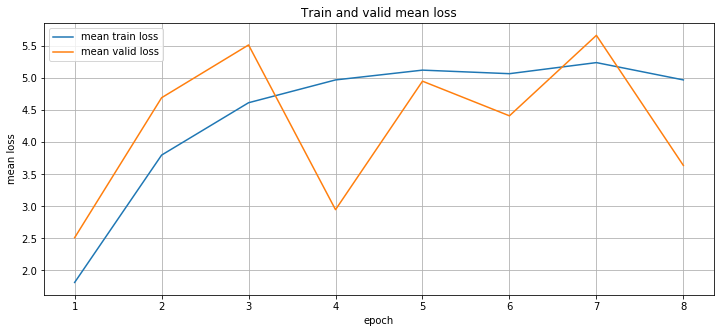

In [55]:
config = RNNConfig(vocab_size=len(TEXT.vocab),
                   rnn_dim=296,
                   embedding_dim=252,
                   learning_rate=0.470,
                   momentum=0.655,
                   epochs=8)

model = AddRNN(config)
 
training_loop_text_classification(model=model,
                                  config=config,
                                  dataholder=b_data,
                                  model_path="temp.pkl")

### Evaluating the model after the training

mean valid acc after training =  0.53125


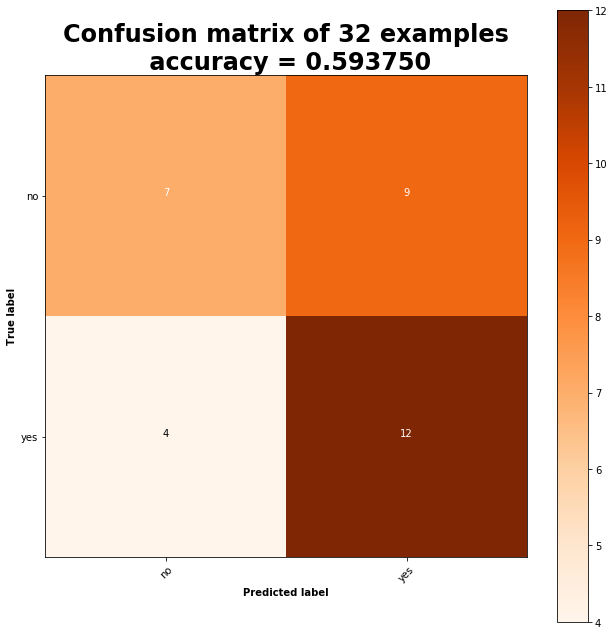

In [58]:
model = AddRNN(config)
model.load_state_dict(torch.load("temp.pkl"))

all_acc = 0
n_iter = 10
for i in range(n_iter):
    s1, s2, and_A, and_B, labels = next(iter(b_data.train_loader))
    s1 = s1.view((s1.shape[1], s1.shape[0]))
    s2 = s2.view((s2.shape[1], s2.shape[0]))
    and_A = and_A.view((and_A.shape[1], and_A.shape[0]))
    and_B = and_B.view((and_B.shape[1], and_B.shape[0]))

    acc, prediction, labels = model.evaluate_labels(s1, s2, labels)
    all_acc += acc

print("mean valid acc after training =  {}".format(all_acc / n_iter))    
plot_confusion_matrix(labels,
                      prediction,
                      classes=["no", "yes"],
                      path="confusion_matrix.png")

In [38]:
# model = AddRNN(config)
# model.load_state_dict(torch.load("temp.pkl"))
# s1, s2, and_A, and_B, labels = next(iter(b_data.valid_loader))
# s1 = s1.view((s1.shape[1], s1.shape[0]))
# s2 = s2.view((s2.shape[1], s2.shape[0]))
# and_A = and_A.view((and_A.shape[1], and_A.shape[0]))
# and_B = and_B.view((and_B.shape[1], and_B.shape[0]))
# _ = model(s1, s2)
# hahat = model.ha.detach().numpy()
# hbhat = model.hb.detach().numpy()
# ha = model.encode(and_A).detach().numpy()
# hb = model.encode(and_B).detach().numpy()

In [39]:
# comp_a = np.mean((hahat - ha) ** 2, axis=1)
# comp_b = np.mean((hbhat - hb) ** 2, axis=1)

In [40]:
# print(comp_a, ">>>>>>>>>>>>>>>>>" ,np.mean(comp_a), np.std(comp_a))

In [41]:
# print(comp_b, ">>>>>>>>>>>>>>>>>" ,np.mean(comp_b), np.std(comp_b))